In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from gensim.corpora import WikiCorpus, dictionary
import gensim.downloader as api
from compare_tools.configuration import wem_loader
from scipy import sparse
import numpy as np
import time
import glob
import os
import pandas as pd
from htrc_features import utils
from motes_corpus.youtube import YTCaptionCorpus
from motes_corpus.subtitles import SubtitleCorpus
from motes_corpus.hathibook import HathiCorpus
from motes_corpus import modeling

Aligning with the GloVe wiki gigaword 300 model, which as 40000 *uncased* tokens, trained on 6B tokens from Wikipedia in 2014.

In [3]:
model = wem_loader('glove-wiki-gigaword-300')

In [4]:
# Write vocab into a gensim dictionary format
dict_path = '/data/motes/gigaword_300_dict.txt'
if not os.path.exists(dict_path):
    with open(dict_path, mode='w') as f:
        f.write('1\n')
        for i, word in enumerate(model.vocab.keys()):
            f.write('{}\t{}\t1\n'.format(i, word))
model_dict = dictionary.Dictionary.load_from_text(dict_path)
n_words = len(model_dict)

In [6]:
n_words, model_dict[12345]

(400000, 'weiss')

## Training Cooccurrence Matrix

GloVe uses a weighting of $(w/w_{max})^\alpha$ for words that occur less than $w_{max}$. In Pennington et al 2014, they use $w_{max}=100$ and $\alpha=\frac{3}{4}$. This will be done later - for now we're just collecting raw cooccurrence counts.


- Good guide: http://www.foldl.me/2014/glove-python/

### Baseline English Wikipedia

This will be the foundation on which the children's corpus is built.

In [526]:
def only_every(gen, n):
    ''' Only return every nth doc.'''
    for i, page in gen:
        if i % n == 0:
            yield page

1

In [ ]:
wiki = WikiCorpus('/data/motes/enwiki/enwiki-latest-pages-articles.xml.bz2', lemmatize=False, dictionary=model_dict)
wikicooc = modeling.train_coocurrence_matrix(wiki.get_texts(), model_dict,
                                             window_size=10, print_every=5000)
sparse.save_npz('/data/motes/enwiki_cooc_raw.npz', wikicooc)

Docs processed: 0	 time: 11s	 docs/second: 0


Stats for partial matrix:
- Full1: Docs processed: 317014   time: 68589s    docs/second: 4
- Full 2: Docs processed: 31254    time: 4179s     docs/second: 7

In [1]:
317014+31254

348268

### Simple Wikipedia

In [522]:
wiki = WikiCorpus('/data/motes/simplewiki/simplewiki-latest-pages-articles.xml.bz2', lemmatize=False, dictionary=model_dict)

In [245]:
word_n = 0
docs = 0
for i, text in enumerate(wiki.get_texts()):
    word_n += len(text)
    docs += 1
    if i % 50000 == 0:
        print(i, end=', ')
print('\n', word_n, docs)

0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 70500, 71000, 71500, 72000, 72500, 73

In [ ]:
wikicooc = modeling.train_coocurrence_matrix(wiki.get_texts(), model_dict,
                                             window_size=10, print_every=2000)
sparse.save_npz('/data/motes/simplewiki_cooc_raw.npz', wikicooc)

### Youtube

In [123]:
caption_paths = glob.glob('/data/motes/yt_captions/**/*')
ytcorpus = YTCaptionCorpus(caption_paths)
ytcorpus.stats()

{'words': 9157014, 'docs': 15037, 'types': 265208}

In [124]:
cooc = modeling.train_coocurrence_matrix(ytcorpus.tokens(), model_dict,
                                         window_size=10, print_every=2000)
sparse.save_npz('/data/motes/yt_cooc_raw_{}.npz'.format(time.strftime('%m-%d')), cooc)

Docs processed: 0	 time: 1s	 docs/second: 0
Docs processed: 2000	 time: 85s	 docs/second: 23
Docs processed: 4000	 time: 228s	 docs/second: 17
Docs processed: 6000	 time: 340s	 docs/second: 17
Docs processed: 8000	 time: 568s	 docs/second: 14
Docs processed: 10000	 time: 802s	 docs/second: 12
Docs processed: 12000	 time: 999s	 docs/second: 12
Docs processed: 14000	 time: 1197s	 docs/second: 11


### Subtitles

In [41]:
subtitle_paths = glob.glob('/data/motes/show_subtitles/**/*')
showcorpus = SubtitleCorpus(subtitle_paths)
showcorpus.stats()

{'words': 12436065, 'docs': 5737, 'types': 493642}

In [ ]:
cooc = modeling.train_coocurrence_matrix(showcorpus.tokens(), model_dict,
                                         window_size=10, print_every=2000)
sparse.save_npz('/data/motes/shows_cooc_raw_{}.npz'.format(time.strftime('%m-%d')), cooc)

Docs processed: 0	 time: 0s	 docs/second: 0
Docs processed: 2000	 time: 708s	 docs/second: 2


### Children's Books

In [48]:
kidsbooks = pd.read_parquet('/data/motes/kids_books.parquet')
book_paths = (['/data/extracted-features-parquet-stubby/{}.tokens.parquet'.format(utils.id_to_stubbytree(htid)) for htid in kidsbooks.htid])
book_paths[0]

'/data/extracted-features-parquet-stubby/uc1/b88/uc1.b4088188.tokens.parquet'

In [156]:
# Estimate based on 1% of the corpus
random.shuffle(book_paths)
sample_prop = .01
sample_size = int(len(book_paths) * sample_prop)
htcorpus = HathiCorpus(book_paths[:sample_size])
s = htcorpus.stats()
s, s['words']/sample_prop, s['docs']/sample_prop

({'words': 5817930, 'docs': 22465, 'types': 104704}, 581793000.0, 2246500.0)

The HathiTrust Children's books had to be processed in parallel because of size, using `scripts/ht_cooc_matrix.py`, so those need to be combined.

In [266]:
%%time
for name, lastdir in [('2005-10', '2005'), ('2000-05', '2000')]:
    cooc = modeling.merge_sparse_matrices(glob.glob('/data/motes/ht_coocs/{}/*'.format(lastdir)))
    sparse.save_npz('/data/motes/ht_coocs/ht_cooc_raw_{}'.format(name), cooc)

# Combine all the decade matrices
#cooc = modeling.merge_sparse_matrices(glob.glob('/data/motes/ht_coocs/ht_cooc_raw_1*'))
#sparse.save_npz('/data/motes/ht_coocs/ht_cooc_raw_all', cooc)

CPU times: user 3min 29s, sys: 28.6 s, total: 3min 58s
Wall time: 3min 58s


### Combine matrixes with weighting

In [349]:
# Get a sense of how big various matrixes are
paths = glob.glob('/data/motes/*npz') + glob.glob('/data/motes/ht_coocs/ht_cooc_raw_[12]*')
for path in paths:
    print(path, '\t', sparse.load_npz(path).tocsr()[:100,:100].sum())

/data/motes/simplewiki_cooc_raw.npz 	 13086210.66666866
/data/motes/yt_cooc_raw_09-07.npz 	 12011316.945634851
/data/motes/shows_cooc_raw_09-07.npz 	 36357764.06587125
/data/motes/ht_coocs/ht_cooc_raw_2005-10.npz 	 10457207.777608508
/data/motes/ht_coocs/ht_cooc_raw_2000-05.npz 	 8335299.301917659
/data/motes/ht_coocs/ht_cooc_raw_1850-1980.npz 	 113350320.77022566
/data/motes/ht_coocs/ht_cooc_raw_1980-90.npz 	 13482573.579135073
/data/motes/ht_coocs/ht_cooc_raw_1990-2000.npz 	 14833244.88504179


In [355]:
all_dists = []
quantiles = [.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .96, .97, .98, .99, .997, .999, .9999]
for path in paths:
    m = sparse.load_npz(path)
    #m.data[m.data < 1] = 0
    #m.eliminate_zeros()
    a = np.quantile(m.data, quantiles)
    del m
    b = pd.Series(dict(zip(quantiles, a)))
    b.name = path
    all_dists.append(b)
pd.DataFrame(all_dists).round(2)

,0.0100,0.0500,0.1000,0.2000,0.3000,0.4000,0.5000,0.6000,0.7000,0.8000,0.9000,0.9500,0.9600,0.9700,0.9800,0.9900,0.9970,0.9990,0.9999
/data/motes/simplewiki_cooc_raw.npz,0.33,0.33,0.33,0.33,0.67,0.67,0.67,1.00,1.00,1.67,3.33,6.67,8.00,11.00,16.33,32.67,105.00,289.33,1982.03
/data/motes/yt_cooc_raw_09-07.npz,0.10,0.10,0.20,0.40,0.50,0.70,0.80,1.00,1.30,2.10,4.70,10.40,13.40,18.60,29.20,61.40,215.86,642.96,5401.40
/data/motes/shows_cooc_raw_09-07.npz,0.10,0.10,0.20,0.30,0.50,0.60,0.80,0.90,1.20,2.00,4.60,11.00,14.60,20.70,33.70,76.20,295.70,967.90,10097.11
/data/motes/ht_coocs/ht_cooc_raw_2005-10.npz,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.03,0.08,0.20,0.27,0.38,0.64,1.49,6.08,20.18,212.96
/data/motes/ht_coocs/ht_cooc_raw_2000-05.npz,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.03,0.08,0.19,0.26,0.37,0.61,1.43,5.77,19.13,200.72
/data/motes/ht_coocs/ht_cooc_raw_1850-1980.npz,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.03,0.06,0.15,0.40,0.54,0.79,1.36,3.34,14.97,54.28,643.40
/data/motes/ht_coocs/ht_cooc_raw_1980-90.npz,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.04,0.09,0.22,0.29,0.42,0.71,1.67,6.90,23.47,253.57
/data/motes/ht_coocs/ht_cooc_raw_1990-2000.npz,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.04,0.09,0.22,0.29,0.42,0.70,1.65,6.84,23.13,249.92


Check distributions, if eliminating all cooccurrences below 1. As we see below, ther distributions end up being very similar for the Bag-of-words tokens.

In [322]:
all_dists = []
quantiles = [.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99, .997, .999, .9999]
for path in paths:
    m = sparse.load_npz(path)
    m.data[m.data < 1] = 0
    m.eliminate_zeros()
    a = np.quantile(m.data, quantiles)
    del m
    b = pd.Series(dict(zip(quantiles, a)))
    b.name = path
    all_dists.append(b)
pd.DataFrame(all_dists).round(2)

,0.0100,0.0500,0.1000,0.2000,0.3000,0.4000,0.5000,0.6000,0.7000,0.8000,0.9000,0.9500,0.9900,0.9970,0.9990,0.9999
/data/motes/simplewiki_cooc_raw.npz,1.00,1.00,1.00,1.00,1.00,1.00,1.33,1.67,2.33,3.33,7.00,13.67,67.67,210.00,554.67,3459.20
/data/motes/yt_cooc_raw_09-07.npz,1.00,1.00,1.00,1.20,1.40,1.70,2.10,2.70,3.80,6.00,13.23,28.80,158.70,535.39,1597.83,10706.78
/data/motes/shows_cooc_raw_09-07.npz,1.00,1.00,1.00,1.20,1.40,1.70,2.10,2.80,4.00,6.70,15.80,36.50,232.00,858.13,2688.03,26113.54
/data/motes/ht_coocs/ht_cooc_raw_1850-1980.npz,1.01,1.07,1.15,1.34,1.60,1.96,2.48,3.30,4.77,7.91,18.44,41.60,245.32,853.54,2527.43,22068.87
/data/motes/ht_coocs/ht_cooc_raw_1980-90.npz,1.01,1.07,1.14,1.32,1.56,1.87,2.34,3.05,4.28,6.83,14.93,31.63,167.89,549.61,1591.98,10823.81
/data/motes/ht_coocs/ht_cooc_raw_1990-2000.npz,1.01,1.07,1.14,1.32,1.55,1.87,2.33,3.04,4.27,6.81,14.85,31.45,165.43,539.70,1540.72,11077.11


In [356]:
ordered_weights = [('/data/motes/simplewiki_cooc_raw.npz', 1.5, .34),
                   ('/data/motes/yt_cooc_raw_09-07.npz', 2, .2),
                   ('/data/motes/shows_cooc_raw_09-07.npz', 2, .2),
                   ('/data/motes/ht_coocs/ht_cooc_raw_1850-1980.npz', .1, 1),
                   ('/data/motes/ht_coocs/ht_cooc_raw_1980-90.npz', .2, 1),
                   ('/data/motes/ht_coocs/ht_cooc_raw_1990-2000.npz', .3, 1),
                   ('/data/motes/ht_coocs/ht_cooc_raw_2000-05.npz', .4, 1),
                   ('/data/motes/ht_coocs/ht_cooc_raw_2005-10.npz', .5, 1)
                  ]
                   
for i, (path, weight, drop_below) in enumerate(ordered_weights):
    print(path)
    partial_mat = sparse.load_npz(path)
    if drop_below:
        # Drop really low coocurrences
        partial_mat.data[partial_mat.data < drop_below] = 0
        partial_mat.eliminate_zeros()
    if i == 0:
        full_mat = partial_mat
    else:
        full_mat += partial_mat
    # For stats - collect
full_mat

/data/motes/simplewiki_cooc_raw.npz
/data/motes/yt_cooc_raw_09-07.npz
/data/motes/shows_cooc_raw_09-07.npz
/data/motes/ht_coocs/ht_cooc_raw_1850-1980.npz
/data/motes/ht_coocs/ht_cooc_raw_1980-90.npz
/data/motes/ht_coocs/ht_cooc_raw_1990-2000.npz
/data/motes/ht_coocs/ht_cooc_raw_2000-05.npz
/data/motes/ht_coocs/ht_cooc_raw_2005-10.npz


<400000x400000 sparse matrix of type '<class 'numpy.float64'>'
	with 50926469 stored elements in Compressed Sparse Row format>

In [128]:
# Combine with the OG EN Wiki
# Load Sparse Matrix
cooc = sparse.load_npz('/data/motes/coocs/enwiki_cooc_317k_raw.npz')
print(cooc.data.max(), cooc.data.min(), cooc.data.sum())

# Drop bottom 20% of (rare) coocs
cutoff = np.quantile(cooc.data.data, .2)
cooc.data[cooc.data < cutoff] = 0
cooc.eliminate_zeros()

margins = np.array(cooc.sum(0))[0]

ordered_weights = [#('/data/motes/coocs/simplewiki_cooc_raw.npz', .5, .2),
                   #('/data/motes/coocs/yt_cooc_raw_09-07.npz', .5, .2),
                   ('/data/motes/coocs/shows_cooc_raw_09-07.npz', 1, .2),
                   #('/data/motes/coocs/ht_coocs/ht_cooc_raw_1850-1980.npz', .1, 1),
                   #('/data/motes/coocs/ht_coocs/ht_cooc_raw_1980-90.npz', .2, 1),
                   #('/data/motes/coocs/ht_coocs/ht_cooc_raw_1990-2000.npz', .3, 1),
                   #('/data/motes/coocs/ht_coocs/ht_cooc_raw_2000-05.npz', .4, 1),
                   #('/data/motes/coocs/ht_coocs/ht_cooc_raw_2005-10.npz', .5, 1)
                  ]

for i, (path, weight, drop_below) in enumerate(ordered_weights):
    print(path)
    partial_mat = sparse.load_npz(path)
    # Scale to same size as enwiki, then scale
    size_diff = (margins[:200] / np.array(partial_mat.sum(0))[0][:200])
    scaling = weight * size_diff[~np.isnan(size_diff)].mean()
    if drop_below:
        # Drop really low coocurrences
        partial_mat.data[partial_mat.data < drop_below] = 0
        partial_mat.eliminate_zeros()
    cooc += (partial_mat * scaling)
sparse.save_npz('/data/motes/coocs/shows_w_en.npz', cooc)

23077519.848555967 0.1 5016099596.501346
/data/motes/coocs/shows_cooc_raw_09-07.npz


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [357]:
a = np.quantile(full_mat.data, quantiles)
b = pd.Series(dict(zip(quantiles, a)))
b

0.0100        0.200000
0.0500        0.400000
0.1000        0.536830
0.2000        0.666667
0.3000        0.674892
0.4000        0.900000
0.5000        1.000000
0.6000        1.333333
0.7000        2.000000
0.8000        3.249331
0.9000        8.120466
0.9500       19.700000
0.9600       25.892300
0.9700       36.499497
0.9800       58.628357
0.9900      128.877679
0.9970      475.963757
0.9990     1493.601192
0.9999    14222.358332
dtype: float64

## Train New Model

### Truncate

If we were to truncate the vocabulary at $n$, what % of cooccurrences would be retained vs dropped?

<AxesSubplot:>

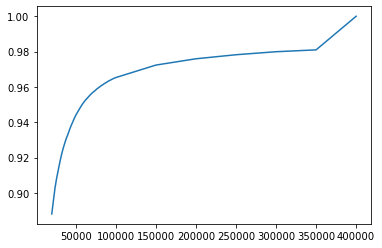

In [216]:
import pandas as pd
percent_of_all_weight = []
s = cooc.sum()
m = cooc.tocsc()
for i in range(0, 400000, 2000):
    p = m[:i,:i].sum() / s
    percent_of_all_weight.append(p)
del m
pd.Series(percent_of_all_weight, index=list(range(0, 100000, 2000))+list(range(100000, 450000, 50000))).iloc[10:].plot()

## Train with Python GloVe
 - this doesn't do fine-tuning, but that's fine for now

In [7]:
from glove import Corpus, Glove

In [127]:
n = 100000
fpath = '/data/motes/coocs/all_weighted_3_model.npz'
just_name = os.path.splitext(os.path.split(fpath)[-1])[0]

cooc = sparse.load_npz(fpath)
# Load Sparse Matrix
print(cooc.data.max(), cooc.data.min(), cooc.data.sum())

# Truncate just to top n words in vocab
m = cooc.tocsc()[:n, :n].tocoo()
glove = Glove(no_components=300, learning_rate=0.05) 
glove.fit(m, epochs=100, no_threads=25, verbose=True)
del m
dictionary = dict(list(model_dict.token2id.items())[:n])
glove.add_dictionary(dictionary)

# Convert to keyed vectors and save
kv = modeling.glove_to_keyedvectors(glove)
kv.save('/data/motes/models/{}_{}k.kv'.format(just_name, int(n/1000)))

277861985.5636423 0.4 56405196386.71731
Performing 100 training epochs with 25 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [426]:
kv.save('/data/motes/all_weighted_1_model.txt')

In [463]:
n = 100000
word_sums = pd.Series(np.array(full_mat.sum(1))[:n, 0], index=glove.dictionary.keys())

# only preserve vocab where there have been enough words seen
with open('/data/motes/all_weighted_1_model_include_vocab.txt', mode='w') as f:
    f.write('\n'.join(word_sums[word_sums > 500].index.tolist()))

10650